In [75]:
# Adversarial Neural Cryptography - https://arxiv.org/pdf/1610.06918.pdf
# Alternative implementation of the paper above using RNNs

In [76]:
# Necessary imports
import torch
import random

import numpy as np
from torch import nn

import matplotlib.pyplot as plt

In [77]:
# Define the length of the key and the message
pln_txt_len = cip_txt_len = 16
sec_key_len = 8

In [78]:
# Function to generate a random plain text and a secret key
def create_batch(plain_text_len, secret_key_len, batch_size):
    plain_text = torch.zeros(batch_size, plain_text_len)
    secret_key = torch.zeros(batch_size, secret_key_len)
    
    for i in range(batch_size):
        for j in range(plain_text_len):
            plain_text[i][j] = random.randint(0, 1)
        for j in range(secret_key_len):
            secret_key[i][j] = random.randint(0, 1)
            
    return plain_text.float(), secret_key.float()

plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, 256)
print(plain_text.shape, secret_key.shape)

torch.Size([256, 16]) torch.Size([256, 8])


In [79]:
# Define the device

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

NVIDIA GeForce RTX 2070 Super with Max-Q Design


In [80]:
# Alice's network
# Add plain text and secret key and pass it through a linear layer
# Note: plain text and secret key are of the same length

class AliceRNN_Net(nn.Module):
    def __init__(self, plain_text_len, secret_key_len, cipher_text_len, hidden_size=128):
        super(AliceRNN_Net, self).__init__()   
        self.input_size  = plain_text_len + secret_key_len  # L + K
        self.output_size = cipher_text_len                  # L
        self.hidden_size = hidden_size                      # H
        
        self.C   = nn.Linear(self.input_size, self.output_size)
        self.W   = nn.Linear(1, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.U   = nn.Linear(2*hidden_size, 1)
        
        self.V   = nn.Linear(2*hidden_size, 1)
        
    def init_hidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size).to(device)
        
    def forward(self, plain_text, secret_key, hidden=None):
        x = torch.cat((plain_text, secret_key), dim=1)      # B x (L + K)
        x = self.C(x).unsqueeze(2)                          # B x L x 1
        x = torch.relu(x)                                   # B x L x 1
        x = self.W(x)                                       # B x L x H
        x = torch.relu(x)                                   # B x L x H
        
        if hidden is None:
            hidden = self.init_hidden(x.shape[0])           # N x B x H
        x, hidden = self.gru(x, hidden)                     # B x L x 2H, 2 x B x H
        
        x = self.U(x)                                       # B x L x 1
        x = torch.sigmoid(x)                                # B x L x 1
        x = x.view(-1, self.output_size)                    # B x L
        return x
    
    def encrypt(self, plain_text, secret_key):
        encrypted_text = self.forward(plain_text, secret_key)
        return torch.as_tensor((encrypted_text - 0.5) > 0, dtype=torch.float32)

In [81]:
class BobRNN_Net(nn.Module):
    def __init__(self, plain_text_len, secret_key_len, cipher_text_len, hidden_size=128):
        super(BobRNN_Net, self).__init__()   
        self.input_size  = cipher_text_len + secret_key_len     # L + K
        self.output_size = plain_text_len                       # L
        self.hidden_size = hidden_size                          # H 
        
        self.C   = nn.Linear(self.input_size, self.output_size)
        self.W   = nn.Linear(1, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.U   = nn.Linear(2*hidden_size, 1)
        
    def init_hidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size).to(device)
        
    def forward(self, cipher_text, secret_key, hidden=None):
        x = torch.cat((cipher_text, secret_key), dim=1)         # B x (L + K)
        x = self.C(x).unsqueeze(2)                              # B x L x 1
        x = torch.relu(x)                                       # B x L x 1
        x = self.W(x)                                           # B x L x H
        x = torch.relu(x)                                       # B x L x H
        
        if hidden is None:
            hidden = self.init_hidden(x.shape[0])               # N x B x H
        x, hidden = self.gru(x, hidden)                         # B x L x 2H, 2 x B x H
        
        x = self.U(x)                                           # B x L x 1
        x = torch.sigmoid(x)                                    # B x L x 1
        x = x.view(-1, self.output_size)                        # B x L
        return x
    
    def decrypt(self, cipher_text, secret_key):
        decrypted_text = self.forward(cipher_text, secret_key)
        return torch.as_tensor((decrypted_text - 0.5) > 0, dtype=torch.float32)

In [82]:
class EveRNN_Net(nn.Module):
    def __init__(self, plain_text_len, cipher_text_len, hidden_size=128):
        super(EveRNN_Net, self).__init__()  
        self.input_size  = cipher_text_len                      # L 
        self.output_size = plain_text_len                       # L
        self.hidden_size = hidden_size                          # H 
        
        self.W   = nn.Linear(1, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.U   = nn.Linear(2 * hidden_size, 1)
        
    def init_hidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size).to(device)
        
    def forward(self, cipher_text, hidden=None):
        x = cipher_text.unsqueeze(2)                            # B x L x 1
        x = self.W(x)                                           # B x L x H
        x = torch.relu(x)                                       # B x L x H
        
        if hidden is None:
            hidden = self.init_hidden(x.shape[0])               # N x B x H
        x, hidden = self.gru(x, hidden)                         # B x L x 2H, 2 x B x H
        
        x = self.U(x)                                           # B x L x 1
        x = torch.sigmoid(x)                                    # B x L x 1
        x = x.view(-1, self.output_size)                        # B x L
        return x
    
    def eavesdrop(self, cipher_text):
        eavesdrop_text = self.forward(cipher_text)
        return torch.as_tensor((eavesdrop_text - 0.5) > 0, dtype=torch.float32)

In [83]:
# Declare the hidden size
hidden_size = 128

# Instantiate the models
Alice = AliceRNN_Net(pln_txt_len, sec_key_len, cip_txt_len, hidden_size).to(device)
Bob   = BobRNN_Net(pln_txt_len, sec_key_len, cip_txt_len, hidden_size).to(device)
Eve   = EveRNN_Net(pln_txt_len, cip_txt_len, hidden_size).to(device)

print("All models instantiated successfully !!!")

All models instantiated successfully !!!


In [84]:
# Hyperparameters
n_epochs   = 200
eve_edge   = 2

train_size = 2 ** 12
batch_size = 128

# Define the optimizers
lr = 0.0008

optim_Alice = torch.optim.Adam(Alice.parameters(), lr=lr)
optim_Bob   = torch.optim.Adam(Bob.parameters(), lr=lr)
optim_Eve   = torch.optim.Adam(Eve.parameters(), lr=lr)

optimizers  = [optim_Alice, optim_Bob, optim_Eve]

In [85]:
# Custom Loss functions
criterion = nn.L1Loss()

class AliceBobLoss(nn.Module):
    def __init__(self, sec_key_len):
        super(AliceBobLoss, self).__init__()
        self.N = sec_key_len
    
    def forward(self, plain_text, decrypted_text, alice_eve_loss):
        loss = torch.mean(torch.sum(torch.abs(plain_text - decrypted_text), axis=-1))
        loss += (((self.N / 2) - alice_eve_loss)**2 / (self.N / 2)**2)
        return loss
    
class AliceEveLoss(nn.Module):
    def __init__(self):
        super(AliceEveLoss, self).__init__()
    
    def forward(self, plain_text, eavesdrop_text):
        return torch.mean(torch.sum(torch.abs(plain_text - eavesdrop_text), axis=-1))
    
criterion_AliceBob = AliceBobLoss(sec_key_len)
criterion_AliceEve = AliceEveLoss()
criterions = [criterion_AliceBob, criterion_AliceEve]

def hamming_distance(x, y):
    return torch.mean(torch.sum(torch.abs(x - y), axis=-1))

In [86]:
# Train the networks
# Eve is trained eve_edge times for every training of Alice and Bob
alice_bob_dist, alice_eve_dist = np.zeros(n_epochs * (train_size // batch_size)), np.zeros(n_epochs * (train_size // batch_size))

def train(Alice, Bob, Eve, criterions, optimizers, train_size=10000, eve_edge=2, n_epochs=100, batch_size=256):
    print("Training started ...")
    
    # Initialize the losses
    n_batches = train_size // batch_size
    
    for epoch in range(n_epochs):
        bob_dist, eve_dist = np.zeros(n_batches), np.zeros(n_batches)

        for batch in range(n_batches):  
            # for _ in range(1):      
            plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, batch_size)
            plain_text, secret_key = plain_text.to(device), secret_key.to(device)
        
            optimizers[0].zero_grad()
            optimizers[1].zero_grad()
            
            # Train Alice and Bob        
            encrypted_text = Alice(plain_text, secret_key)
            decrypted_text = Bob(encrypted_text, secret_key)
            eavesdrop_text = Eve(encrypted_text)

            # Expectation of the loss
            alice_eve_loss = criterions[1](plain_text, eavesdrop_text)
            bob_loss = criterions[0](plain_text, decrypted_text, alice_eve_loss)
            loss_bob = criterions[1](plain_text, decrypted_text).item()
            
            # Back-propagation
            bob_loss.backward()
            
            optimizers[0].step()
            optimizers[1].step()

            # Train Eve
            loss_eve = 0
            for _ in range(eve_edge):
                plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, batch_size)
                plain_text, secret_key = plain_text.to(device), secret_key.to(device)
                
                optimizers[2].zero_grad() 
                
                # Detach the encrypted text from the graph to prevent backpropagation
                encrypted_text = Alice(plain_text, secret_key)
                eavesdrop_text = Eve(encrypted_text)
            
                # Expectation of the loss 
                eve_loss = criterions[1](plain_text, eavesdrop_text)
                loss_eve += eve_loss.item()
                
                # Back-propagation                    
                eve_loss.backward()
                
                optimizers[2].step()
            loss_eve /= eve_edge * 1.0
                
            alice_bob_dist[epoch * n_batches + batch] = bob_dist[batch] = loss_bob
            alice_eve_dist[epoch * n_batches + batch] = eve_dist[batch] = loss_eve
                
            print("\rEpoch: {}/{} | Batch: {}/{} | Bob: {:.4f} | Eve: {:.4f}".format(epoch+1, n_epochs, batch+1, n_batches, bob_loss, eve_loss), end="", flush=True)
              
        print("\rEpoch: {}/{} | Average number of bits wrong (of {}) Bob: {} , Eve: {}".format(epoch+1, n_epochs, sec_key_len, np.round(np.mean(bob_dist), 4), np.round(np.mean(eve_dist), 4)), end='\n', flush=True)
    
    print("\rTraining completed !!!")
    
# Set the models to train mode
Alice.train()
Bob.train()
Eve.train()

train(Alice, Bob, Eve, criterions, optimizers, train_size, eve_edge, n_epochs, batch_size)

Training started ...
Epoch: 1/200 | Average number of bits wrong (of 8) Bob: 7.9816 , Eve: 8.0024
Epoch: 2/200 | Average number of bits wrong (of 8) Bob: 7.9981 , Eve: 7.6599
Epoch: 3/200 | Average number of bits wrong (of 8) Bob: 7.9935 , Eve: 6.8338
Epoch: 4/200 | Average number of bits wrong (of 8) Bob: 6.9013 , Eve: 6.6391
Epoch: 5/200 | Average number of bits wrong (of 8) Bob: 7.8184 , Eve: 7.1328
Epoch: 6/200 | Average number of bits wrong (of 8) Bob: 7.9775 , Eve: 6.8369
Epoch: 7/200 | Average number of bits wrong (of 8) Bob: 8.0434 , Eve: 6.8977
Epoch: 8/200 | Average number of bits wrong (of 8) Bob: 8.0088 , Eve: 7.7937
Epoch: 9/200 | Average number of bits wrong (of 8) Bob: 8.0107 , Eve: 7.3481
Epoch: 10/200 | Average number of bits wrong (of 8) Bob: 8.0129 , Eve: 6.8586
Epoch: 11/200 | Average number of bits wrong (of 8) Bob: 7.9544 , Eve: 6.5513
Epoch: 12/200 | Average number of bits wrong (of 8) Bob: 7.9565 , Eve: 6.6502
Epoch: 13/200 | Average number of bits wrong (of 8) 

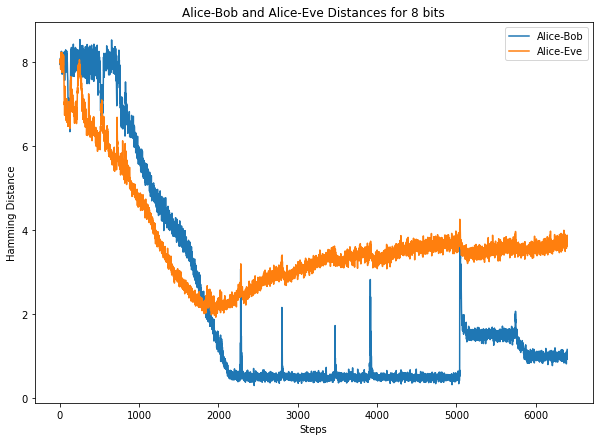

In [87]:
# Plot the results
plt.figure(figsize=(10, 7))
plt.title("Alice-Bob and Alice-Eve Distances for {} bits".format(sec_key_len))

steps = np.arange(alice_bob_dist.shape[0])
plt.plot(steps, alice_bob_dist, label="Alice-Bob")
plt.plot(steps, alice_eve_dist, label="Alice-Eve")
plt.ylabel("Hamming Distance")
plt.xlabel("Steps")

plt.legend()
plt.show()